In [1]:
import tensorflow as tf
import keras
from draw_candle_image import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta.trend
from ta import add_all_ta_features
from ta.utils import dropna
import ta
import ta.momentum
import json
from common_train_utils import *
from functools import partial
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
import tensorflow_docs.modeling
from model_code import *
import os

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpsltwtv1i\tensorboard_logs


In [4]:
dataset_folder = "./vnindex_dataset_12_2_3_2007_2024_test_2022_2023_2024_macd_signal"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_test = load_dataset_test(dataset_folder)

In [7]:
for images, labels in dataset_test.take(2):
    print(images.shape)
    print(labels.shape)
    

(287, 287, 3)
(18, 4)
(287, 287, 3)
(18, 4)


In [8]:
image_shape = tuple(images.shape)

In [9]:
image_shape

(287, 287, 3)

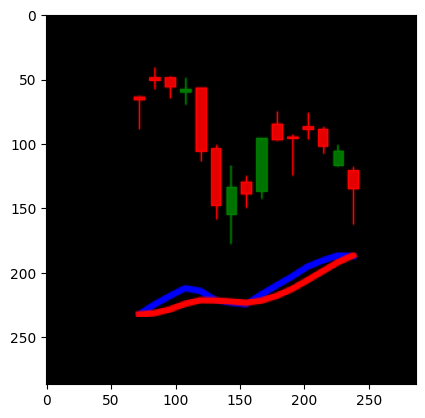

In [10]:
plt.imshow(images)

In [11]:
len(dataset_test)

109

In [12]:
dataset_train = load_dataset_train(dataset_folder, candle_type_and_directory_save)

folder: bullish_engulfing, 		 total: 57 images
folder: bearish_engulfing, 		 total: 58 images
folder: star_doji, 		 total: 0 images
folder: dragonfly_doji, 		 total: 0 images
folder: gravestone_doji, 		 total: 0 images
folder: morning_star, 		 total: 0 images
folder: evening_star, 		 total: 33 images
folder: hammer, 		 total: 25 images
folder: inverted_hammer, 		 total: 28 images
folder: harami_down, 		 total: 44 images
folder: harami_up, 		 total: 63 images
folder: tweezer_top, 		 total: 32 images
folder: tweezer_bottom, 		 total: 27 images
folder: marubozu, 		 total: 67 images
folder: spin, 		 total: 34 images
folder: next_3_day_up, 		 total: 227 images
folder: next_3_day_down, 		 total: 201 images


In [13]:
total_data_train = len(dataset_train)
batch_size = 100

In [14]:
total_data_train

896

In [15]:
dataset_train_1 = dataset_train.batch(batch_size)
dataset_test_1 = dataset_test.batch(batch_size)

In [16]:
transform_function = partial(get_open_close_prices_percent_of_last_days_result, days_result)
dataset_train_2 = dataset_train_1.map(transform_function)
dataset_test_2 = dataset_test_1.map(transform_function)

In [17]:
dataset_test_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3, 2), dtype=tf.float64, name=None))>

In [53]:
def split_cnn(image_shape, days_result):
    inputs = keras.layers.Input(shape=image_shape)
        
    # Các lớp CNN để trích xuất đặc trưng từ ảnh
    x = keras.layers.Conv2D(32, (3, 3), activation='sigmoid')(inputs)
    # x = keras.layers.MaxPooling2D((2, 2))(x)

    a = keras.layers.Permute((3, 1, 2))(x)
    
    flatten = keras.layers.TimeDistributed(keras.layers.Flatten())(a)
    flatten = keras.layers.TimeDistributed(keras.layers.Dense(32))(flatten)
    flatten = keras.layers.TimeDistributed(keras.layers.Dense(32))(flatten)
    lstm_1 = keras.layers.LSTM(64, return_sequences=True)(flatten)
    lstm_1 = keras.layers.TimeDistributed(keras.layers.Dense(2))(lstm_1)
     # Chỉ lấy 3 bước thời gian đầu tiên
    output = keras.layers.Lambda(lambda x: x[:, :days_result, :])(lstm_1)  # Lấy 3 bước đầu
    
    # Xây dựng mô hình
    model = keras.models.Model(inputs=[inputs], outputs=output)
    return model, "split_cnn"

In [54]:
model, model_name = split_cnn(image_shape, days_result)

In [55]:
model_name

'split_cnn'

In [56]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 287, 287, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 285, 285, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_3 (Permute)             │ (None, 32, 285, 285)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 32, 81225)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 32, 32)         │     2,599,232 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 32, 32)         │         1,056 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 32, 2)          │           130 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 3, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,146 (10.02 MB)

 Trainable params: 2,626,146 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=35*40,
    decay_rate=1,
    staircase=False
)


def get_optimizer():
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=10),
        keras.callbacks.TensorBoard(logdir/name)
    ]


In [58]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
    ],
)

In [59]:
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 100

In [ ]:
history = model.fit(
    dataset_train_2, 
    validation_data=dataset_test_2,
    epochs=max_epochs, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=get_callbacks(name_folder_save_metrics)
)

Epoch 1/100


d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_32']. Received: the structure of inputs=*
  warnings.warn(


In [48]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)

In [49]:
save_model(model, model_name)

-- ./vnindex_dataset_12_2_3_2007_2024_test_2022_2023_2024_macd_signal/split_cnn.keras already exists
-- Change to ./vnindex_dataset_12_2_3_2007_2024_test_2022_2023_2024_macd_signal/split_cnn_1.keras
Save to ./vnindex_dataset_12_2_3_2007_2024_test_2022_2023_2024_macd_signal/split_cnn_1.keras


In [50]:
size_histories = {}

In [51]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 1.0)

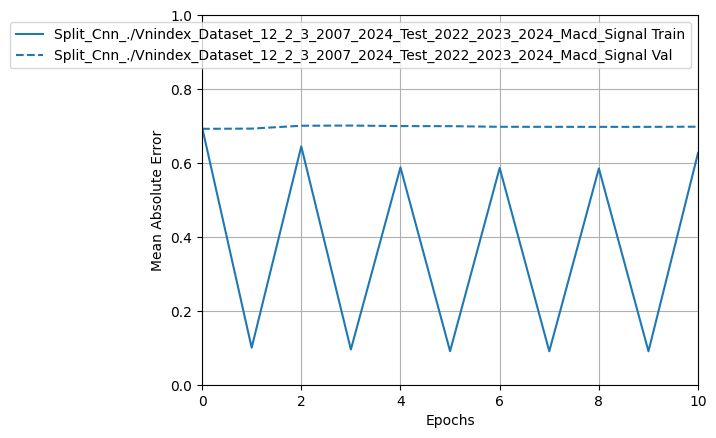

In [52]:
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,1])